# Analysis by Michał Heit EAD PROJECT

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import scipy
import matplotlib.pyplot as plt
from scipy.stats import skew, kurtosis, shapiro
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

Load data and drop column 'Unnamed: 0' which is only indexing.
We can drop Epoch types because when we have dates, hours in normal readable type.
NOTE: WEATHER DATA FROM DAYTON IS PER DAY

In [2]:
dayton_df = pd.read_csv('./datasets/dayton.csv')

epoch_columns = ['Unnamed: 0', 'datetimeEpoch', 'sunriseEpoch', 'sunsetEpoch']
dayton_df.drop(epoch_columns, axis=1, inplace=True)

dayton_df['datetime'] = pd.to_datetime(dayton_df['datetime'])
dayton_df.set_index('datetime', inplace=True)

Load electrical consumption from dayton
NOTE: ELECTRICAL CONSUMPTION IS PER HOUR

In [3]:
electrical_cons_dayton_df = pd.read_csv('./datasets/Energy_consumption_Dayton.csv')
electrical_cons_dayton_df['Datetime'] = pd.to_datetime(electrical_cons_dayton_df['Datetime'])

original_e_cons_df = electrical_cons_dayton_df.copy() # full energy consumption df

Make electrical consumption per day by using groupby and do it with function mean

In [4]:
electrical_cons_dayton_df = electrical_cons_dayton_df.set_index('Datetime').groupby(pd.Grouper(freq='d')).sum()

Let's concatenate electrical and weather df for analyzing

In [5]:
complete_df = pd.concat([electrical_cons_dayton_df, dayton_df], axis=1, join='inner')

First look on dataset, I can see a lot of NaNs in some columns

In [6]:
complete_df

,Energy_MW,tempmax,tempmin,temp,feelslikemax,feelslikemin,feelslike,dew,humidity,precip,...,uvindex,sunrise,sunset,moonphase,conditions,description,icon,stations,source,tzoffset
2004-10-01,44255.0,24.0,6.3,15.4,24.0,5.1,15.4,9.9,73.05,0.60,...,0.0,07:33:19,19:18:34,0.55,"Rain, Partially cloudy",Partly cloudy throughout the day with rain cle...,rain,"['74570099999', '72429613841', '72427699999', ...",obs,NaN
2004-10-02,39398.0,18.3,8.1,15.4,18.3,7.6,15.3,9.7,72.24,1.85,...,0.0,07:34:17,19:16:58,0.58,"Rain, Partially cloudy",Partly cloudy throughout the day with early mo...,rain,"['74570099999', '72429613841', '72427699999', ...",obs,NaN
2004-10-03,36689.0,19.7,1.9,10.5,19.7,1.9,10.5,2.0,61.99,0.00,...,0.0,07:35:16,19:15:21,0.62,Clear,Clear conditions throughout the day.,clear-day,"['74570099999', '72429613841', '72427699999', ...",obs,NaN
2004-10-04,46237.0,18.5,7.6,12.7,18.5,6.3,12.2,3.3,54.33,0.00,...,0.0,07:36:15,19:13:46,0.67,Clear,Clear conditions throughout the day.,clear-day,"['74570099999', '72429613841', '72427699999', ...",obs,NaN
2004-10-05,47283.0,16.1,0.9,9.1,16.1,-1.2,8.4,0.8,59.85,0.00,...,0.0,07:37:15,19:12:11,0.71,Clear,Clear conditions throughout the day.,clear-day,"['74570099999', '72429613841', '72427699999', ...",obs,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-07-30,48632.0,24.6,18.3,21.2,24.6,18.3,21.2,17.7,81.14,1.20,...,5.0,06:33:56,20:51:55,0.53,"Rain, Overcast",Cloudy skies throughout the day with rain clea...,rain,"['72429093815', 'KDAY', '74570013840', 'KFFO',...",obs,NaN
2018-07-31,49226.0,25.5,19.4,21.5,25.5,19.4,21.5,19.2,87.07,20.45,...,4.0,06:34:50,20:50:55,0.56,"Rain, Partially cloudy",Partly cloudy throughout the day with a chance...,rain,"['72429093815', 'KDAY', '74570013840', 'KFFO',...",obs,NaN
2018-08-01,49447.0,25.4,19.0,21.4,25.4,19.0,21.4,18.0,81.79,0.00,...,4.0,06:35:45,20:49:52,0.60,Partially cloudy,Partly cloudy throughout the day.,partly-cloudy-day,"['72429093815', 'KDAY', '74570013840', 'KFFO',...",obs,NaN
2018-08-02,52037.0,26.6,18.4,22.7,26.6,18.4,22.7,18.4,78.35,0.00,...,7.0,06:36:40,20:48:48,0.64,Partially cloudy,Partly cloudy throughout the day.,partly-cloudy-day,"['72429093815', 'KDAY', '74570013840', 'KFFO',...",obs,NaN


let's check the percent of nans in columns

In [7]:
missing_columns = complete_df.isnull().sum() / len(complete_df.index) * 100

Missing columns:
* precipprob
* preciptype
* snow
* snowdepth
* windgust
* winddir
* solarradation
* solarenergy
* tzoffset

All of them are mostly empty expect winddir but I don't really think it has some influence on energy. Let's drop these variables.

In [8]:
missing_columns = missing_columns[(missing_columns > 0)]

In [9]:
missing_columns

precipprob        100.000000
preciptype        100.000000
snow               78.654797
snowdepth          71.097923
windgust           46.726014
winddir            14.421365
solarradiation     98.516320
solarenergy        98.516320
tzoffset           48.941642
dtype: float64

In [10]:
complete_df.drop(list(missing_columns.index), inplace=True, axis=1)

I decide to drop description too because we have almost the same information from icon column and it's better to categorize.
To be honest source and stations don't see to give some value to model.

In [11]:
complete_df.drop(['description', 'stations', 'source', 'conditions'], inplace=True, axis=1)

Distribution of variable that I want to predict, We can see a periodic trend. Probably the energy depends on seasons.

<AxesSubplot:xlabel='Lata', ylabel='Energia'>

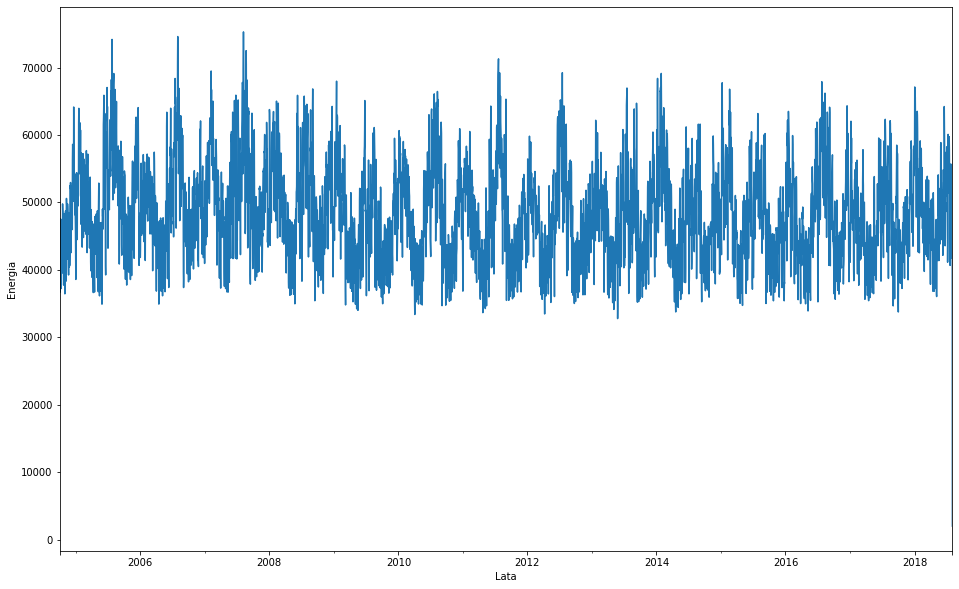

In [12]:
complete_df['Energy_MW'].plot(xlabel='Lata', ylabel='Energia', figsize=(16, 10))

In [13]:
seasons = {1: 'Winter', 2: 'Winter', 3: 'Spring', 4: 'Spring', 5:'Spring', 6: 'Summer', 7: 'Summer', 8: 'Summer', 9: 'Autumn', 10: 'Autumn', 11: 'Autumn', 12: 'Winter'}

complete_df['year'] = complete_df.index.year
complete_df['quarter'] = complete_df.index.quarter
complete_df['month'] = complete_df.index.month
complete_df['week'] = complete_df.index.week
complete_df['day'] = complete_df.index.day
complete_df['week_day'] = complete_df.index.weekday
complete_df['season'] = complete_df['month'].replace(seasons)


/var/folders/48/cclz8phs439d2740cgmcdb8r0000gn/T/ipykernel_4488/1973622772.py:6: FutureWarning: weekofyear and week have been deprecated, please use DatetimeIndex.isocalendar().week instead, which returns a Series.  To exactly reproduce the behavior of week and weekofyear and return an Index, you may call pd.Int64Index(idx.isocalendar().week)
  complete_df['week'] = complete_df.index.week


# 1. PERIODICAL ANALYSIS

Let's check the energy in particular seasons

## 1.1 SEASONS

<AxesSubplot:xlabel='Lata', ylabel='Energia'>

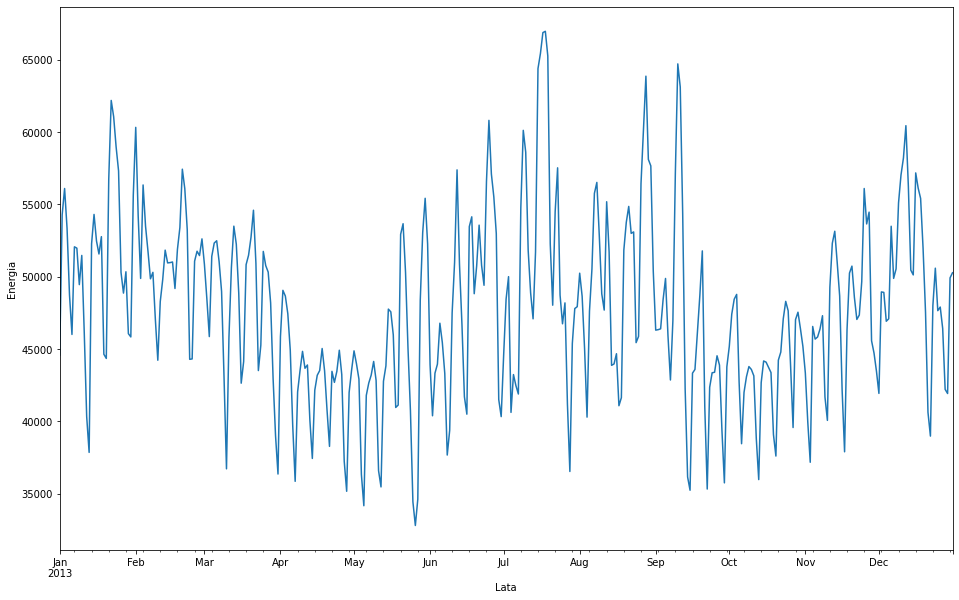

In [14]:
complete_df.loc['2013-01-01':'2013-12-31']['Energy_MW'].plot(xlabel='Lata', ylabel='Energia', figsize=(16, 10))

[Text(0, 0, '45693.7'),
 Text(0, 0, '44918'),
 Text(0, 0, '53008.4'),
 Text(0, 0, '51981.5')]

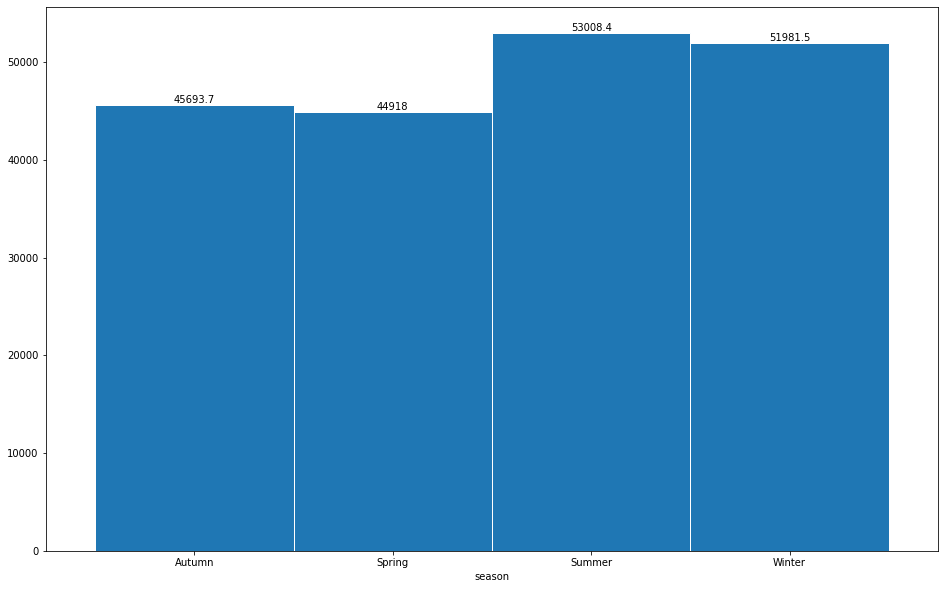

In [15]:

fig, axs = plt.subplots(1, 1, figsize=(16, 10))

complete_df.groupby('season').mean()['Energy_MW'].plot(kind='bar', width=1, edgecolor='white', rot=0, ax=axs)
axs.bar_label(axs.containers[0])

<AxesSubplot:xlabel='season', ylabel='Energy_MW'>

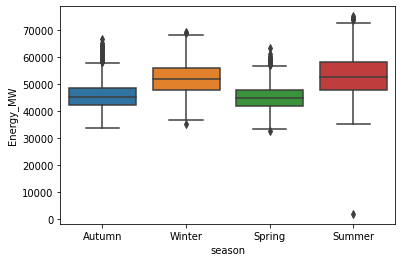

In [16]:
sns.boxplot(data=complete_df, x='season', y='Energy_MW')

We have a significant difference between summer, winter and other seasons.
**So we know that seasons matters** Let's analyze deeper, days.

## 1.2 DAYS

<AxesSubplot:xlabel='Lata', ylabel='Energia'>

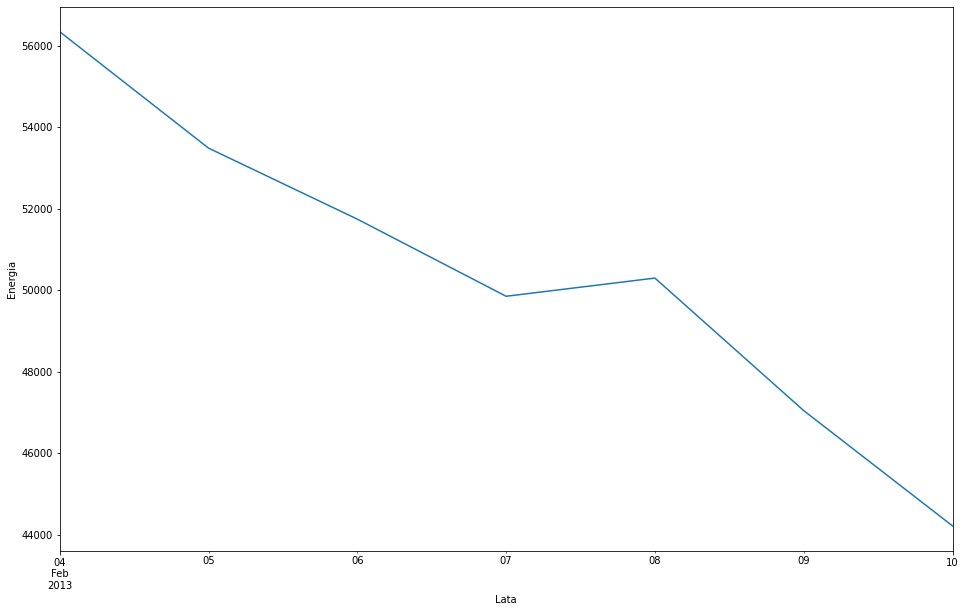

In [17]:
complete_df.loc['2013-02-04':'2013-02-10']['Energy_MW'].plot(xlabel='Lata', ylabel='Energia', figsize=(16, 10))

[Text(0, 0, '50413.3'),
 Text(0, 0, '51517.2'),
 Text(0, 0, '51505.6'),
 Text(0, 0, '51272.7'),
 Text(0, 0, '49976.1'),
 Text(0, 0, '44536.2'),
 Text(0, 0, '43009.5')]

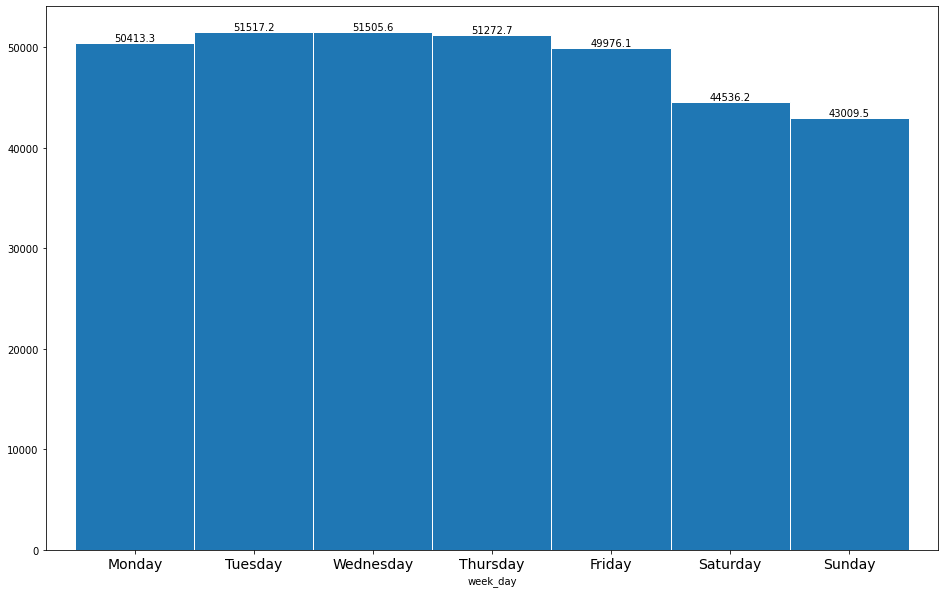

In [18]:
days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

fig, axs = plt.subplots(1, 1, figsize=(16, 10))

complete_df.groupby('week_day').mean()['Energy_MW'].plot(kind='bar', width=1, edgecolor='white', rot=0, ax=axs)
axs.set_xticklabels(days, fontsize='14')
axs.bar_label(axs.containers[0])

<AxesSubplot:xlabel='week_day', ylabel='Energy_MW'>

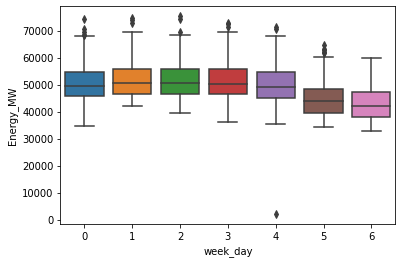

In [19]:
sns.boxplot(data=complete_df, x='week_day', y='Energy_MW')

In working days we have much higher energy consumption, let's see now energy consumption in parts of day.

### 1.3 PARTS OF DAYS

/var/folders/48/cclz8phs439d2740cgmcdb8r0000gn/T/ipykernel_4488/1962884627.py:25: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[7].set_xticklabels(list(parts_day_df.index), fontsize='14')


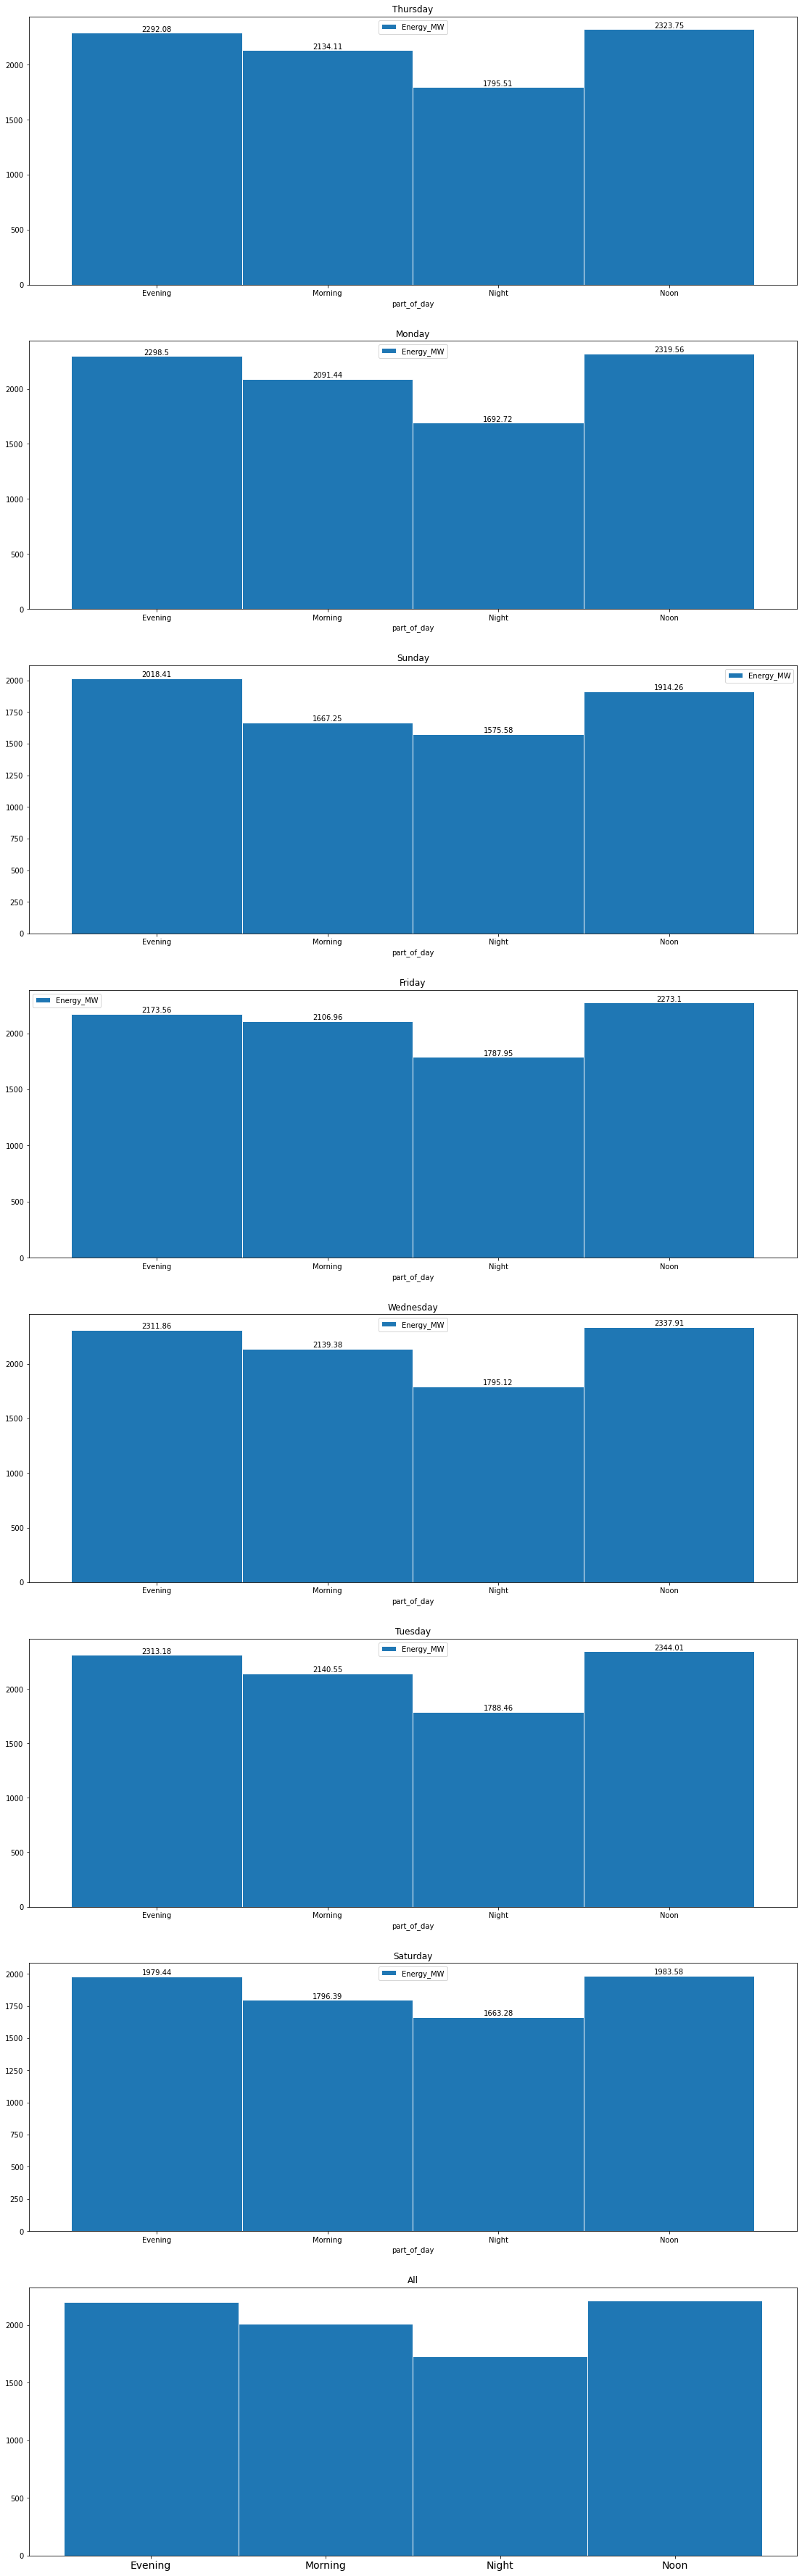

In [20]:
parts_day = {0: 'Night', 6: 'Morning', 12: 'Noon', 18: 'Evening'}
temp_df = original_e_cons_df.set_index('Datetime').groupby(pd.Grouper(freq='6h')).mean()

parts_day_ticks = []
week_day = []
for date in list(temp_df.index):
    parts_day_ticks.append(parts_day[date.hour])
    week_day.append(date.day_name())

temp_df.reset_index(inplace=True)
temp_df.drop('Datetime', inplace=True, axis=1)

temp_df['part_of_day'] = parts_day_ticks
temp_df['week_day'] = week_day

parts_day_df = temp_df.groupby('part_of_day').mean()
parts_in_days_df = temp_df.groupby(['week_day', 'part_of_day']).mean()

fig, axs = plt.subplots(8, 1, figsize=(16, 50))
for i, day in enumerate(set(week_day)):
    parts_in_days_df.loc[day].plot(kind='bar', title=day, ax=axs[i], width=1, edgecolor='white', rot=0)
    axs[i].bar_label(axs[i].containers[0])

axs[7].bar(list(parts_day_df.index), parts_day_df['Energy_MW'], width=1, edgecolor='white')
axs[7].set_xticklabels(list(parts_day_df.index), fontsize='14')
axs[7].set_title('All')
plt.tight_layout(pad=3)


## 1.4 Years, eco-friendly growth

<AxesSubplot:xlabel='ix', ylabel='Energy_MW'>

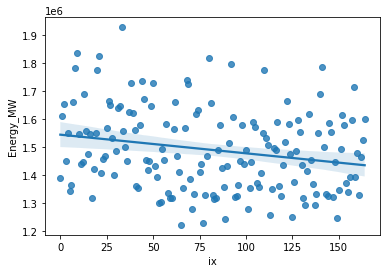

In [21]:
economic_growth_df = complete_df.groupby(pd.Grouper(freq='M')).sum()['Energy_MW'].to_frame('Energy_MW')
economic_growth_df.drop(economic_growth_df.iloc[[0, -1]].index, inplace=True, axis=0)
economic_growth_df["ix"] = range(0, len(economic_growth_df))

sns.regplot(data=economic_growth_df, x='ix', y='Energy_MW')

As we can see from regression the energy consumption is decreasing over time maybe due to more eco-friendly system. So if we want to predict our times energy consumption in next months we should use
maybe 2014-2018 years.

## 1.5 CONCLUSION

* Year does matter because when we want to predict f.e 2018 year we should choose the range from 2014 because of economic growth.
* OVERALL WE HAVE A LITTLE HIGHER ENERGY CONSUMPTION **IN WORKING DAYS, WINTER, SUMMER, EVENING, NOON**,
* In **working days** in morning we have higher energy consumption than in **weekend**
* Day doesn't matter at noon, evening and night.

I also checked population data in Dayton, but I think this feature wouldn't change that much because population changed from 712000 to 742000 over years in 2004-2018

# 2. DISTRIBUTION OF ENERGY

In [22]:
skewness = skew(complete_df['Energy_MW'])
kurt = kurtosis(complete_df['Energy_MW'])

print(f'Skewness: {skewness}, Kurtosis: {kurt}')

Skewness: 0.31432275227739515, Kurtosis: 0.22841777152462983


It means that distribution of energy has right tail, and it's not symmetric also the tails are a little thinner than in normal distribution. It means that find extreme values will be a little harder.
We can check the normal distribution with shapiro test.

In [23]:
alpha = 0.05
print("H0: Data is a normal distribution")
stat, pval = shapiro(complete_df['Energy_MW'])
if pval < alpha:
    print("H0 is rejected")
else:
    print("H0 cannot be rejected")

H0: Data is a normal distribution
H0 is rejected


/Users/michalnt/Desktop/AIR/MGR/2 sem/ead/venv/lib/python3.9/site-packages/scipy/stats/morestats.py:1760: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


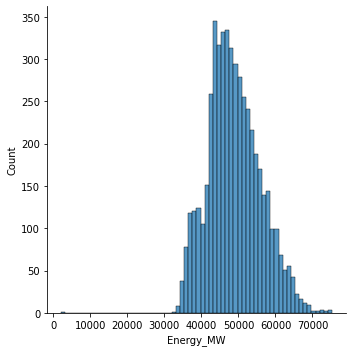

In [24]:
sns.displot(complete_df['Energy_MW'])

# 3. Feature analysis from weather api

Best way to start is to get some fast info about correlation with heatmap.

<AxesSubplot:>

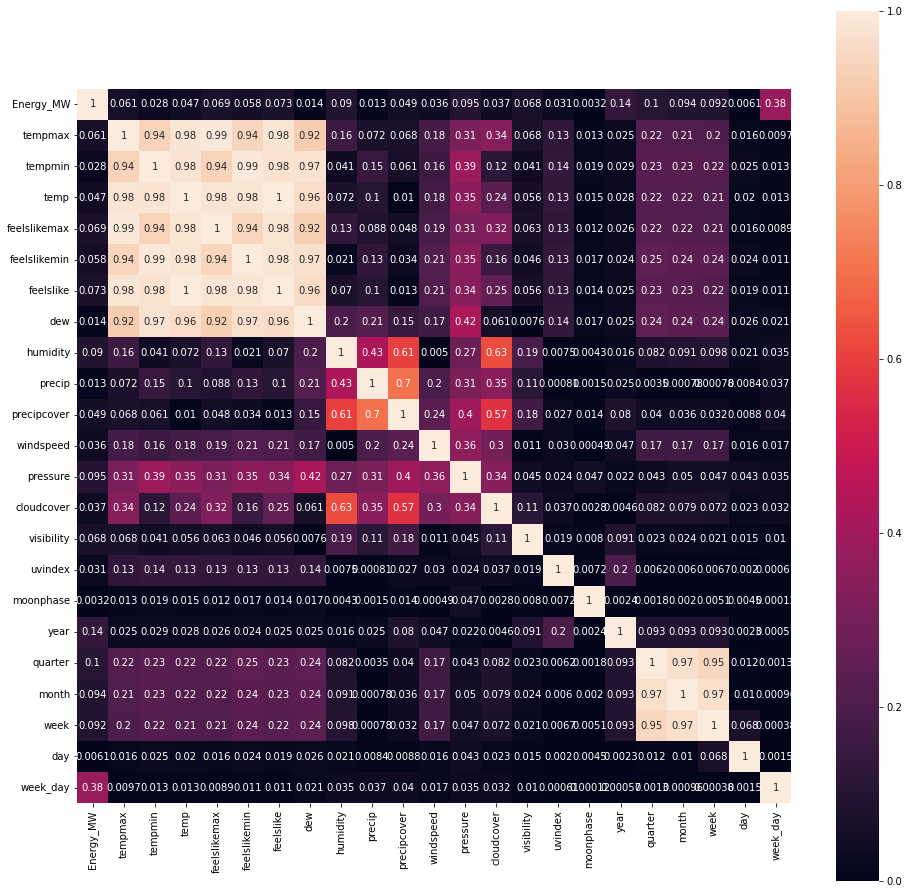

In [25]:
corrmat_complete = abs(complete_df.corr())
fig, axs = plt.subplots(figsize=(16, 16))
sns.heatmap(corrmat_complete, square=True, vmin=0, vmax=1, cmap=sns.color_palette("rocket", as_cmap=True), annot=True)


As we can see tempmin, tempmax, feeslikemax, feelslikemin, feelslike, dew are highly correlated between each other so I will choose one, **temp**
Also all features which causes moisture or rain, like humidity, precip, precipcover, cloudcover are highly correlated between each other.


/Users/michalnt/Desktop/AIR/MGR/2 sem/ead/venv/lib/python3.9/site-packages/seaborn/axisgrid.py:2076: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


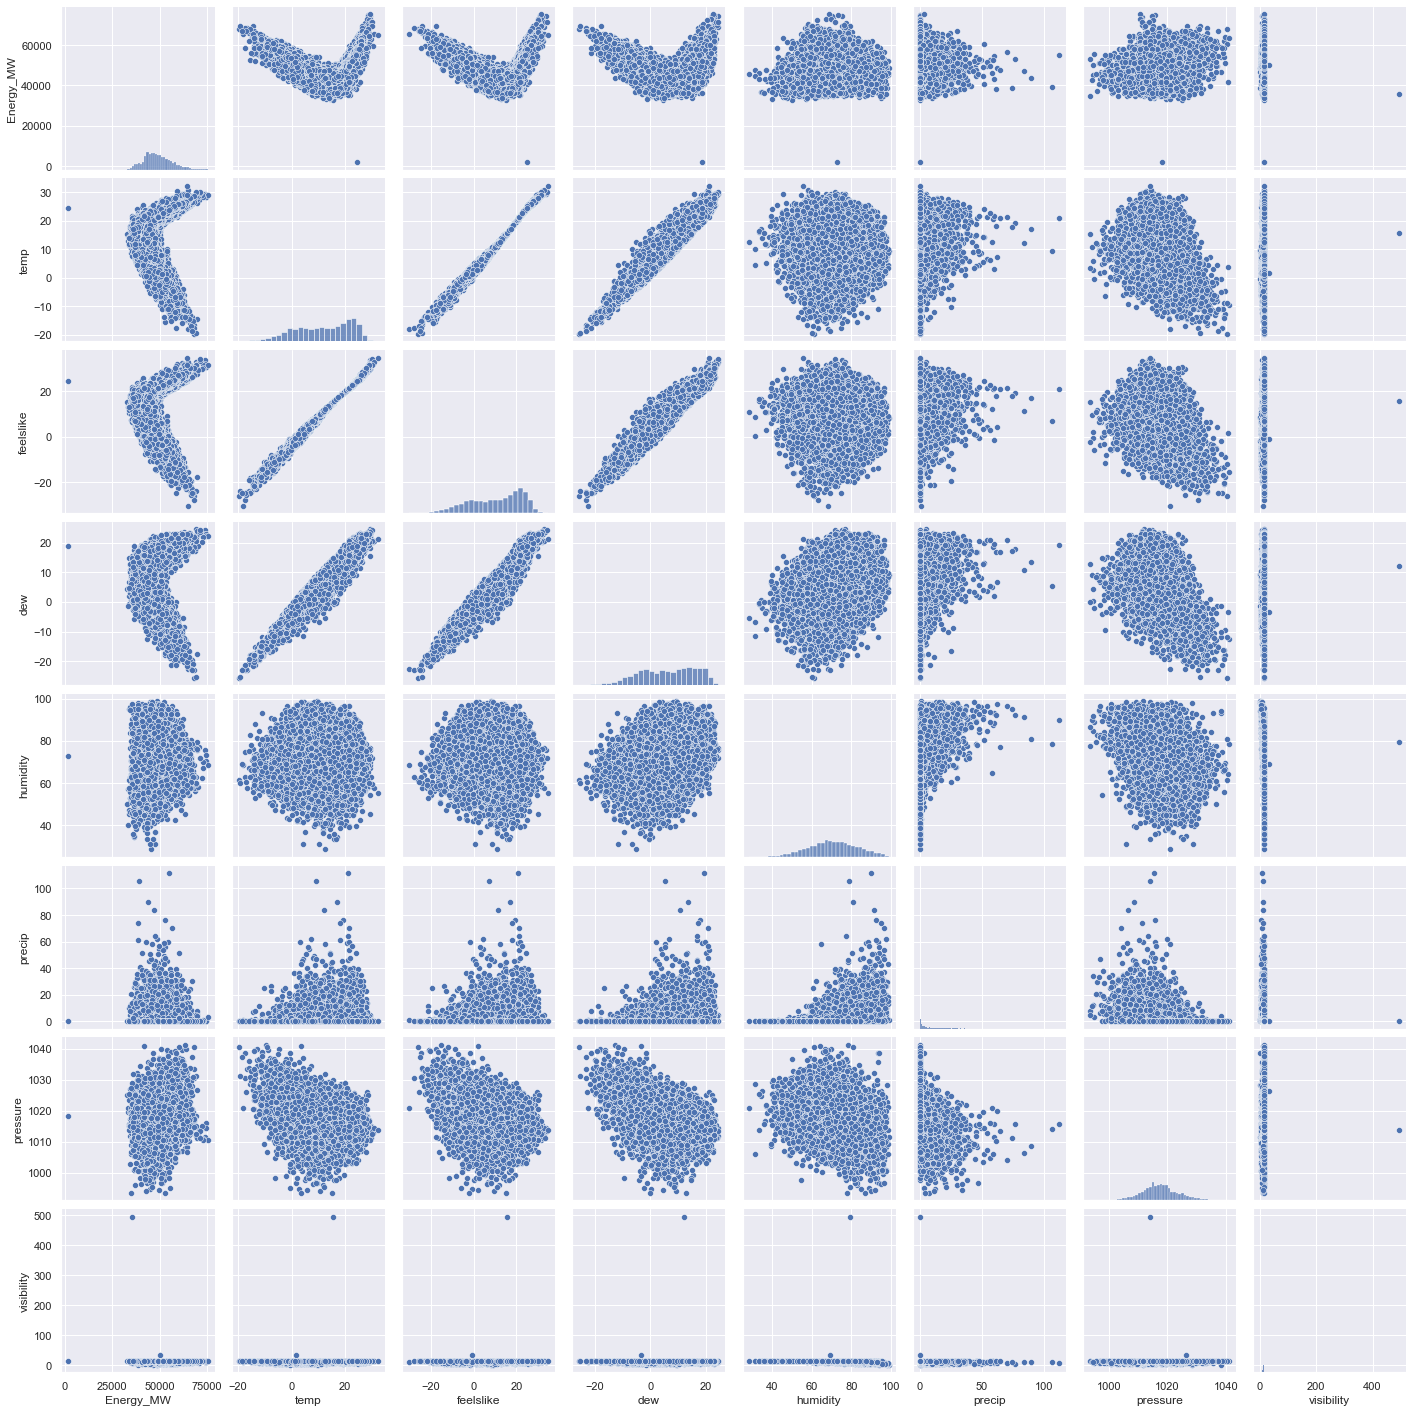

In [26]:
sns.set()
cols = ['Energy_MW', 'temp', 'feelslike', 'dew', 'humidity', 'precip', 'pressure', 'visibility']
sns.pairplot(complete_df[cols], size = 2.5)

From pairplots we can conclude that temp, feelslike and dew are strong correlated between Energy and they are also strong correlated between each other.
I decide to choose feelslike, humidity.

In [27]:
features_to_use = ['Energy_MW', 'feelslike', 'humidity', 'year', 'quarter', 'month', 'week', 'day', 'week_day', 'season']
numerical_to_use = ['Energy_MW', 'feelslike', 'humidity']
final_df = complete_df.copy()[features_to_use]

Checking trends of features from weather api

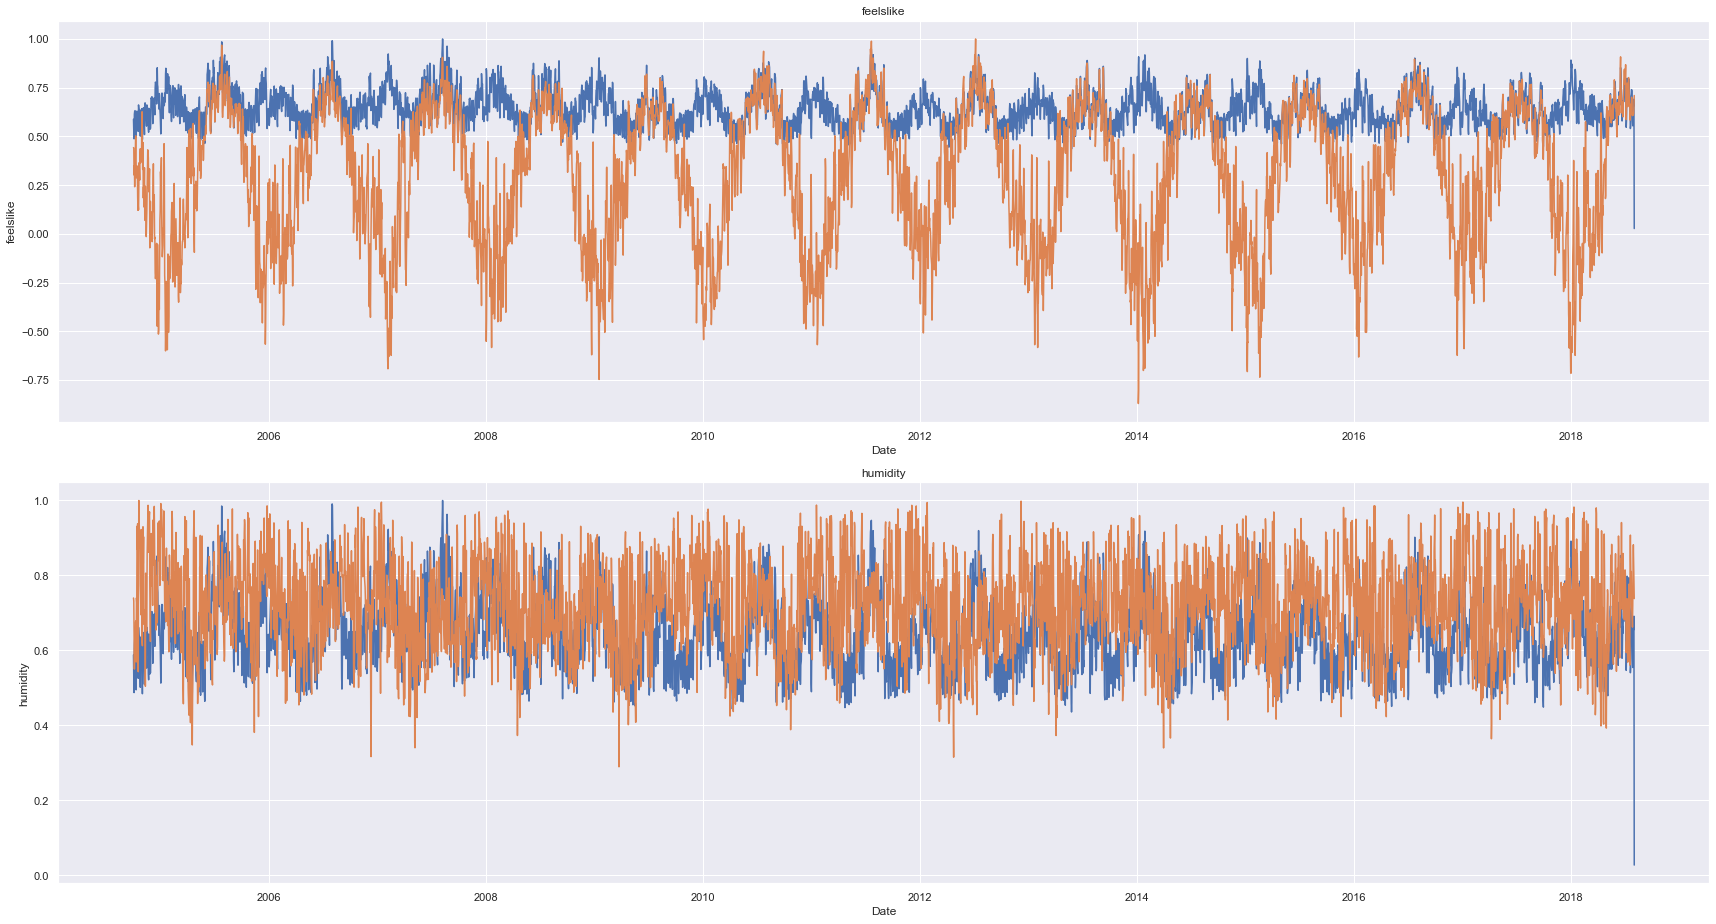

In [28]:
fig, axs = plt.subplots(2, 1, figsize=(24, 13))

for i in range(1, 3):
    axs[i-1].plot(final_df.index, final_df['Energy_MW'] / max(final_df['Energy_MW']))
    axs[i-1].plot(final_df.index, final_df[features_to_use[i]] / max(final_df[features_to_use[i]]))
    axs[i-1].set_title(features_to_use[i])
    axs[i-1].set_xlabel('Date')
    axs[i-1].set_ylabel(features_to_use[i])
plt.tight_layout()

It's strange that when temperature raises up with energy consumption, but I think it's due to air conditioning.

# 4. Feature engineering

In [29]:
#mean = np.mean(final_df['Energy_MW'])
#std = np.std(final_df['Energy_MW'])

#final_df["target"] = final_df['Energy_MW'].add(-mean).div(std)
#sns.distplot(final_df["target"])

# LAG FEATURES


In [30]:
#for t in range(1,31):
 #   final_df["lag_" + str(t)] = final_df['Energy_MW'].shift(t)

#final_df

# ROLLING WINDOW
How about calculating some statistical values based on past values? This method is called the rolling window method because the window would be different for every data point.

In [31]:
#for t in [7, 14, 30, 90, 365]:
 #   final_df[["window_movave" + str(t), "window_movstd" + str(t), "window_movmax" + str(t) ,"window_movmin" + str(t)]] = final_df['Energy_MW'].rolling(t).agg([np.mean, np.std, np.max, np.min])

In [32]:
#final_df

## 4.3 OHT

In [33]:
from sklearn.preprocessing import OneHotEncoder

cat_features = ['year', 'quarter', 'month', 'week', 'day', 'week_day', 'season']
encoded_features = []

for feature in cat_features:
    encoded_feat = OneHotEncoder().fit_transform(final_df[feature].values.reshape(-1, 1)).toarray()
    n = final_df[feature].nunique()
    cols = ['{}_{}'.format(feature, n) for n in range(1, n + 1)]
    encoded_df = pd.DataFrame(encoded_feat, columns=cols)
    encoded_df.index = final_df.index
    encoded_features.append(encoded_df)


final_df = pd.concat([final_df, *encoded_features], axis=1)
final_df

,Energy_MW,feelslike,humidity,year,quarter,month,week,day,week_day,season,...,week_day_2,week_day_3,week_day_4,week_day_5,week_day_6,week_day_7,season_1,season_2,season_3,season_4
2004-10-01,44255.0,15.4,73.05,2004,4,10,40,1,4,Autumn,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
2004-10-02,39398.0,15.3,72.24,2004,4,10,40,2,5,Autumn,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
2004-10-03,36689.0,10.5,61.99,2004,4,10,40,3,6,Autumn,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0
2004-10-04,46237.0,12.2,54.33,2004,4,10,41,4,0,Autumn,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2004-10-05,47283.0,8.4,59.85,2004,4,10,41,5,1,Autumn,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-07-30,48632.0,21.2,81.14,2018,3,7,31,30,0,Summer,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2018-07-31,49226.0,21.5,87.07,2018,3,7,31,31,1,Summer,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2018-08-01,49447.0,21.4,81.79,2018,3,8,31,1,2,Summer,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2018-08-02,52037.0,22.7,78.35,2018,3,8,31,2,3,Summer,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


# 5. MODELS

In [34]:
mean = np.mean(final_df['Energy_MW'])
std = np.std(final_df['Energy_MW'])

final_df["target"] = final_df['Energy_MW'].add(-mean).div(std)
final_df['feelslike'] = final_df['feelslike'].add(-final_df['feelslike'].mean()).div(final_df['feelslike'].std())
final_df['humidity'] = final_df['humidity'].add(-final_df['humidity'].mean()).div(final_df['humidity'].std())


## 5.1 First model predict first 6 months of 2018

In [54]:
X = final_df.drop(['Energy_MW', 'target', *cat_features], axis=1)
y = final_df['target']


X_train = X.loc['2014':'2017-12-31']
X_test = X.loc['2018':'2018-06-30']
y_train = y.loc['2014':'2017-12-31'].to_frame()
y_test = y.loc['2018':'2018-06-30'].to_frame()



In [55]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error

reg = RandomForestRegressor().fit(X_train, y_train)
p_train = reg.predict(X_train)
p_test = reg.predict(X_test)


/var/folders/48/cclz8phs439d2740cgmcdb8r0000gn/T/ipykernel_4488/4210541414.py:5: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  reg = RandomForestRegressor().fit(X_train, y_train)


In [56]:
y_train['predicted'] = p_train
y_test['predicted'] = p_test
y_train = y_train.add(mean) * std
y_test = y_test.add(mean) * std

y_train = y_train.groupby(pd.Grouper(freq='w')).sum()
y_test = y_test.groupby(pd.Grouper(freq='w')).sum()

mae_test = mean_absolute_error(y_test['target'], y_test['predicted'])
mae_train = mean_absolute_error(y_train['target'], y_train['predicted'])

print(mae_train, mae_test)

1984.6572248684733 5078.752692332635


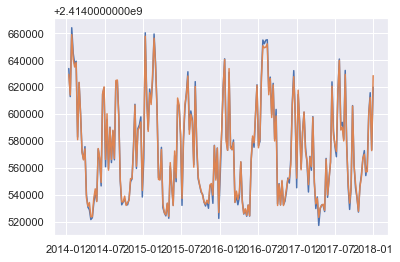

In [63]:
plt.plot(y_train.iloc[1:].index, y_train['target'].iloc[1:])
plt.plot(y_train.iloc[1:].index, y_train['predicted'].iloc[1:])

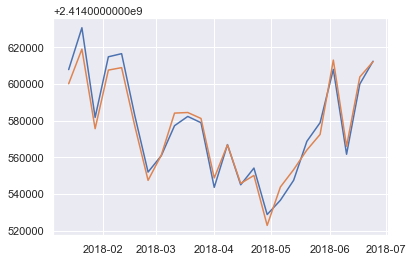

In [66]:
plt.plot(y_test.iloc[1:-1].index, y_test['target'].iloc[1:-1])
plt.plot(y_test.iloc[1:-1].index, y_test['predicted'].iloc[1:-1])

## 5.2 First model predict first 6 months of 2018